# Hochschule Bonn-Rhein-Sieg

# Neural Networks, WS17/18

# Assignment 06 (13-November-2017)

##  Debaraj Barua, Naresh Kumar Gurulingan

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
import IPython

---
## Question 1:

Read chapter 4 from Haykin’s book (2nd edition), starting from section 4.1 to 4.6(including 4.6). Summarize or sketch your insights in mind-map or an outline or a summary.

### Answer 1:

#### Error Propagation:
- Forward Pass
    - Synaptic weights of network are all fixed
- Backward Pass
    -  Synaptic weights are all adjusted in accordance with an error correction rule.
    - Actual response of the network is subtracted form the desired response to produce an error signal.
    - The error signal is then propagated backward through the network, against the direction of the synaptic connections - hence the name "error back-propagation"
    
#### Characteristics
1. Non-linear activation function
    - Model includes a noninear activation function.
    - The non-linearity is smooth (i.e., differentiable everywhere). Eg, sigmoidal nonlinearity, $y=\frac{1}{1+e^{-v_j}}$
    
2. Hidden Neurons
    -  The netowrk contains one or more layyers of hidden neurons that are not part of the input or output of the network.
    - These hidden neurons enable learning of complex tasks by extraction of more meaningful features from input patterns.
    
3. Connectivity
    -  Network exhibits high degrees of connectivity determined by the synapses of the network.

#### Types of Signals in Multilayer perceptron
- Function Signals or input signal
- Error Signals
    -  Originates at the output neuron and prpagates backward (layer by layer) through the network.

#### Back-propagation Algorithm
$$\Delta w_{ji}(n)=-\eta\delta_j y_i(n)$$
Where, 
\begin{align*}
\delta_j&\text{ is the local gradient for neuron j}\\
\eta&\text{ is the learning rate}\\
y_i&\text{ is the input signal of neuron j}\\
&\text{ i.e., the ouput of neuron i from the previous layer}
\end{align*}

- Cases:
    - $j$ is a output neuron
    - $j$ is a hidden neuron

\begin{align*}
\delta_j&=\begin{cases}
                -\phi'(v_j)(d_j-y_j)\\
                -\phi'(v_j)\sum_{k\in C}\delta_k w_{kj}
            \end{cases}
\end{align*}
Where, $C$ denotes the set of neurons in the layer following the one containing $j$

#### Phases of Computation
- *Forward Pass*:
    - Run the NN and compute the error for each neuron of the output layer using the known desired output signal.
- *Backward Pass*
    - start at the output layer, and pass the errors backwards through the network, layer by layer, by recursively computing the local gradient of each neuron.
    - It is derived from chain rule, and needs a differentiable squashing function.

#### Rate of Learning
- If $\eta$ is small, the learning rate is slower, as such convergence is slow.
- On the other hand, if $\eta$ is large, the change in weight is large, which may lead to oscillatory (unstable) behaviour.
- To overcome the above, a *momentum* term ($\alpha$) is included in the delta rule.
$$\underbrace{\Delta w_{ji}(n)=\alpha \Delta w_{ji}(n-1)-\eta\delta_j(n) y_i(n)}_\text{Generalized Delta Rule}$$
- The $\alpha$ acts as a balancing factor by accelerating the descent in setady downhill direction and stabilizes the effect in direction that oscillate in time.

#### Modes of Training
1. Sequential Mode (*online, pattern or stochastic mode*):
    - The inputs and the desired outputs are presented one after the other and sequential forward and backward computations are performed, and update weights after each input-output.
    
2. Batch Mode
    - Weights are updated after the presentation of all the training examples that constitute and epoch.
    - Cost function for a particular epich is considered as the average squared error.
        $$\xi_{av}=\frac{1}{2N}\sum_{n=1}^{N}\sum_{j=C}e_j^2(n)$$
       $e_j(n)$ pertains to output neuron $j$ for training example $n$
    - For a learning rate parameter $\eta$, the adjustment applied to the synaptic weight $w_{ji}$, is defined by the delta rule
        \begin{align*}
            \Delta w_{ji} &=-\eta\frac{\delta \xi_{av}}{\delta w_{ji}}\\
                          &=-\frac{\eta}{N}\sum_{n=1}^{N}e_j(n)\frac{\delta e_j(n)}{\delta w_{ji}}
        \end{align*}
- Although sequential mode has several disadvantages, however, it is still popular because:
    - Simple to implement.
    - Provides effective solution to large and difficult problems.
    
#### Stopping Criteria
- *Average squared error change*: Absolute rate of change in the average squared error per epoch is sufficiently small.
- *Generalization based criterion*: After each epoch the NN is tested for generalization. If the generalization performance is adequate then stop. Here, generalization means how well the I/O mapping computed by the network represents the new data.

#### Steps of Back-propagation algorithm:
1. Initialization.
2. Presenting of training examples.
3. Forward Computaion.
4. Backward Computaion.
5. Iteration.


#### Heuristics to imporove Back-propagation algorithm
1. Sequential versus batch update
2. Maximizing Information content
    - Every training example presented to the algorithm should be chosen on the basis that it's information content is largest possible.
3. Activation function
    - A multilayer perceptron trained with the back propagation algorithm may, in general, learn faster when the sigmoid activation function built into the neuron model of the network is antisymmetric than when it is nonsymmetric.
    - An activation function $\varphi(v)$ is antisymmetric if $$\varphi(-v)=-\varphi (v)$$
4. Target values
    - Desired responses should be chosen within the range of the sigmoid activation function.
5. Normalizing Inputs
    - Each input needs to be preprocessed so that it's mean value, averaged over the entire training set, is close to zero.
6. Initialization
    - It is desirable for the uniform distributuion, from which the synaptic weights are selected to have a mean of zero, and a variance equal to the reciprocal of the number of synaptic connections of a neuron.
7. Learning from hints
    - This is achieved by allowing prior information that we may have abbout the unknown function to be included in the learning process.
    - Such information may include invariance properties, symmetries or any other information.
8. Learning Rates
    - Learning rates may be adapted according to the below heuristics:
        - Every weight should have it's own learning rate
        - Every learning rate should be allowed to vary from one iteration to the next.

---
## Question 2:

For this task you have to program the back-propogation (BP) for multi layered perceptron (MLP). Design your implementation for general NN with arbitrary many hidden layers. The test case is as follows:  2-2-1 multi layered perceptron (MLP) with sigmoid activation function on XOR data.

In [3]:
class NeuralNetwork():
    """
    3 layer neural network with 1 input layer, 1 hidden layer, 
    1 output layer...
    2-2-1 Neural Network..
    """
    def __init__(self, num_hidden_neurons = 2, learning_rate = 1, epochs = 100000,
                 num_inputs = 2, zero_weight_init = False, epsilon= 1e-3):
        # Layer 0 --> input, Layer 1 --> hidden, Layer 2 --> output
        if zero_weight_init == False:
            np.random.seed(0)
            # weights and biases randomly initialized...
            self.w_layer01 = np.random.rand(num_inputs + 1, num_hidden_neurons)
            self.w_layer12 = np.random.rand(num_hidden_neurons + 1, 1)
        else:
            # weights and biases initialized to zero...
            self.w_layer01 = np.zeros((num_inputs + 1, num_hidden_neurons))
            self.w_layer12 = np.zeros((num_hidden_neurons + 1, 1))
            
        self.num_hidden_neurons = num_hidden_neurons
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.epochs = epochs
        
    def non_linearity(self, value, derivative = False):
        if derivative == True: # return slope of sigmoid..
            return value * (1. - value)
        # included to avoid overflow in numpy exponent..
        value = np.array(value, dtype = np.float128)
        value = np.clip( value, -500, 500 )
        # return sigmoid activation value...
        return 1./(1. + np.exp(-value)) 
        
    def train(self, input_array, output_array):
        # appending 1 for bias corresponding input..
        layer0 = np.insert(input_array, 0, 1, axis = 1)
        iteration, conv_count = 0, 0
        while(True):
            layer1_local_field = layer0.dot(self.w_layer01)
            layer1_output = self.non_linearity(layer1_local_field)
            # appending 1 for bias corresponding to output neuron..
            layer1_output = np.insert(layer1_output, 0, 1, axis = 1)
            
            layer2_local_field = layer1_output.dot(self.w_layer12)
            layer2_output = self.non_linearity(layer2_local_field)
            
            # negative of error..
            layer2_error = -(output_array - layer2_output)
            layer2_delta = layer2_error * self.non_linearity(
                layer2_output, derivative = True)
            
            layer1_error = layer2_delta.dot(self.w_layer12.T)
            layer1_delta = layer1_error * self.non_linearity(
                layer1_output, derivative = True)
            # removing delta corresponding to appended input..
            layer1_delta = np.delete(layer1_delta, 0, 1)
            
            # update weights based on error and slope of sigmoid...
            self.w_layer12 -= self.learning_rate * (
                layer1_output.T.dot(layer2_delta))
            
            self.w_layer01 -= self.learning_rate * (
                layer0.T.dot(layer1_delta))
            # mean training error...
            training_error = np.mean(np.abs(layer2_error))
            
            if np.all(layer2_delta < self.epsilon):
                conv_count += 1
            else:
                conv_count = 0
            
            if iteration % 100000 == 0:
                print 'Epoch: ', iteration, '......', 'Training Error: ', (
                    training_error)
            # convergence after low delta 3 consecutive times..
            if iteration > self.epochs or conv_count > 3: 
                break
            
            iteration += 1
                
        print '-----------------------------------------------------------'
        if iteration > self.epochs: 
            print 'Max epochs reached...'
        else:
            print 'Epoch: ', iteration, '......', 'Training Error: ', (
                    training_error)
            print 'Error has converged...'
        print '-----------------------------------------------------------'
        return [training_error, iteration]
                
    def predict(self, input_array, labels= []):
        layer0 = np.insert(input_array, 0, 1, axis = 1)
        layer1_local_field = layer0.dot(self.w_layer01)
        layer1_output = self.non_linearity(layer1_local_field)
        layer1_output = np.insert(layer1_output, 0, 1, axis = 1)
        
        layer2_local_field = layer1_output.dot(self.w_layer12)
        layer2_output = self.non_linearity(layer2_local_field)
        
        if labels == []:
            # predicted result is returned..
            return layer2_output
        else:
            layer2_error = layer2_output - labels
            # average generalization error is returned..
            return np.mean(np.abs(layer2_error))

In [26]:
# XOR..
input_data = np.array([[0., 1.], [1., 0.], [1., 1.], [0., 0.]])
labels = np.array([1., 1., 0., 0.]).reshape(-1, 1)

print input_data.shape
print labels.shape

(4, 2)
(4, 1)


## 2) a) Experiments with initial weights

### i) Train the network with zero initial weights i.e. $w_{ij} = 0$.

In [27]:
network = NeuralNetwork(zero_weight_init= True)
# training with unbalanced data...
error = network.train(input_data[0:3,:], labels[0:3])[0]
error = network.train(input_data[1:4,:], labels[1:4])[0]

# training with all data samples...
error = network.train(input_data, labels)[0]

Epoch:  0 ...... Training Error:  0.5
-----------------------------------------------------------
Epoch:  1864 ...... Training Error:  0.0227265023782
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.349817768718
-----------------------------------------------------------
Epoch:  3 ...... Training Error:  0.349793241012
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.266918558042
-----------------------------------------------------------
Epoch:  3 ...... Training Error:  0.266925151402
Error has converged...
-----------------------------------------------------------


In [28]:
for data in input_data:
    print data, '--->', network.predict(data.reshape(1, -1))[0][0]

[ 0.  1.] ---> 0.981594131461
[ 1.  0.] ---> 0.981666598164
[ 1.  1.] ---> 0.0316529296636
[ 0.  0.] ---> 0.999316886986


## ii) Train with random initial weights:

In [7]:
# training network..
network = NeuralNetwork(zero_weight_init= False)
error = network.train(input_data, labels)[0]

Epoch:  0 ...... Training Error:  0.497746545722
-----------------------------------------------------------
Epoch:  2172 ...... Training Error:  0.0297755638824
Error has converged...
-----------------------------------------------------------


In [8]:
# testing the network..
for data in input_data:
    print data, '--->', network.predict(data.reshape(1, -1))[0][0]

[ 0.  1.] ---> 0.971526233568
[ 1.  0.] ---> 0.971535907171
[ 1.  1.] ---> 0.0300228422105
[ 0.  0.] ---> 0.0321023200595


## Comparision and Comments on convergence:

Weights initialized to zero:

        The weights do not update when all data points are taken as one input matrix. Gradient of the output neuron ends up having 2 positive and 2 negative equal values. This results in 0 weight update between hidden and output layer as the input to the output neuron are all equal. The weights between input and hidden layer also do not update because no gradient is propogated backwards.
        
        Hence, the network is trained with two sets of unbalanced data to cover the input space and then with the entire input space. However, there is still 1 misclassification probably because the weights are stuck in a local minimum.
        
        A total of 1870 epochs is taken for the training process.

Weights initialized to random values:

        With random weight initialization, the error converges in 2172 epochs and all data points are correctly classified.
    
---

## b. Experiment with different learning rates e.g. 0.1, 0.3, 0.5, 0.9:

In [9]:
learning_rates = [0.1, 0.3, 0.5, 0.9]
converged_error = []
epochs = []
for rate in learning_rates:
    network = NeuralNetwork(learning_rate=rate)
    result = network.train(input_data, labels)
    converged_error.append(result[0])
    epochs.append(result[1])

print 'Errors after convergence: '
print '[learning_rate, converged error]'
learn_error = np.array(zip(learning_rates, converged_error))
print learn_error
print '-----------------------------------------------------------'
print 'Epochs taken for convergence: '
print '[learning_rate, epochs]'
learn_epoch = np.array(zip(learning_rates, epochs))
print learn_epoch

Epoch:  0 ...... Training Error:  0.497746545722
-----------------------------------------------------------
Epoch:  21696 ...... Training Error:  0.0298068204029
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.497746545722
-----------------------------------------------------------
Epoch:  7234 ...... Training Error:  0.029799343336
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.497746545722
-----------------------------------------------------------
Epoch:  4342 ...... Training Error:  0.0297898331004
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.497746545722
-----------------------------------------------------------
Epoch:  2413 ...... Training Error:  0.0297794384891
Error has converged...
-----------------------------------------------------------
Errors after converg

## Compare the convergence and plot some resulting surfaces:

## Plot:

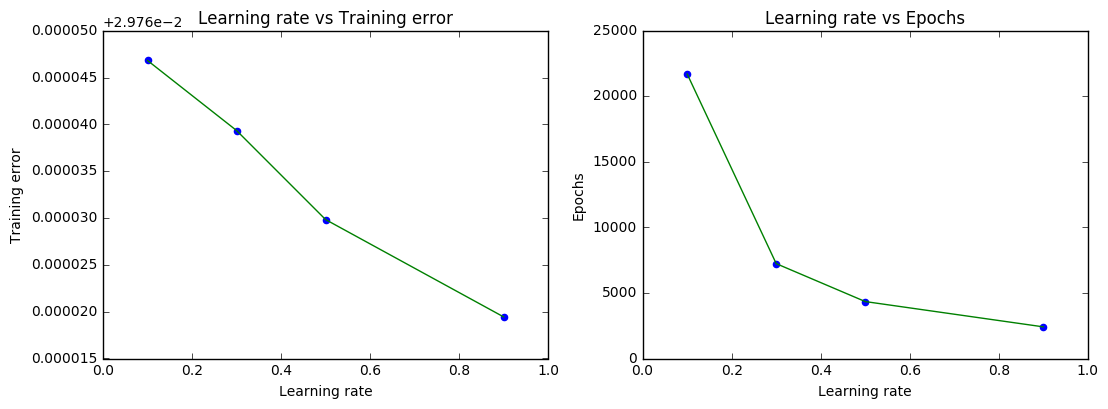

In [10]:
figure = plt.figure(1)
figure.set_figheight(5)
figure.set_figwidth(12)

figure.add_subplot(1, 2, 1)
plt.plot(learn_error[:,0], learn_error[:,1], color = 'g')
plt.xlabel('Learning rate')
plt.ylabel('Training error')
plt.title('Learning rate vs Training error')
plt.scatter(learn_error[:,0], learn_error[:,1], color = 'b')

figure.add_subplot(1, 2, 2)
plt.tight_layout(pad= 4.00)
plt.plot(learn_epoch[:,0], learn_epoch[:,1], color = 'g')
plt.xlabel('Learning rate')
plt.ylabel('Epochs')
plt.title('Learning rate vs Epochs')
plt.scatter(learn_epoch[:,0], learn_epoch[:,1], color = 'b')

plt.show()

## Comparision of convergence:

    Convergence happens faster with increase in learning rate as can be seen from the plot.
---

## Question 3:

Investigate the use of back-propagation learning using a sigmoidal nonlinearity to achieve one-to-one mappings, as described here:

For each mapping, do the following:

1. Set up two sets of data, one for network training, and the other for testing.

2. Use the training data set to compute the synaptic weights of the network, assumed to have a single hidden layer.

3. Evaluate the computation accuracy of the network by using the test data. Use a single hidden layer but with a variable number of hidden neurons. Investigate how the network performance is affected by varying the size of the hidden layer.

In [11]:
## Required functions....

def plot_results(hidden_neurons, train_error, test_error, epochs,
                 plot_title):
    print 'Training error after convergence: '
    print '[Hidden neurons, converged training error]'
    print np.array(zip(hidden_neurons, train_error))
    print '--------------------------------------------------------------------'
    print 'Test error: '
    print '[Hidden neurons, test error]'
    print np.array(zip(hidden_neurons, test_error))
    
    figure = plt.figure(1)
    figure.set_figheight(4)
    figure.set_figwidth(10)

    figure.add_subplot(1, 2, 1)
    plt.plot(hidden_neurons, train_error, color = 'r', label= "Training error")
    plt.scatter(hidden_neurons, train_error, color = 'c')
    plt.plot(hidden_neurons, test_error, color = 'g', label= "Test error")
    plt.scatter(hidden_neurons, test_error, color = 'm')
    plt.xlabel('Number of Hidden Neurons')
    plt.ylabel('Error')
    plt.title(plot_title+ ': Error Plot')
    plt.legend(loc=0)
    figure.add_subplot(1, 2, 2)
    plt.tight_layout(pad= 4.00)
    plt.plot(hidden_neurons, epochs, color = 'b')
    plt.scatter(hidden_neurons, epochs, color = 'g')
    plt.xlabel('Number of Hidden Neurons')
    plt.ylabel('Epochs')
    plt.title(plot_title+ ': Epochs Plot')
    plt.show()

def obtain_performance(x, y, hidden_neurons):
    data = np.hstack((x, y))
    np.random.seed(0)
    # randomly shuffle data..
    np.random.shuffle(data)
    # split data..80 percent training, 20 percent test..
    train_data, test_data = np.vsplit(data, [data.shape[0]*8/10])

    train_error = []
    test_error = []
    epochs = []

    for number in hidden_neurons:
        # initialize network..
        network = NeuralNetwork(num_inputs= 1,
                            num_hidden_neurons= number)
        # train network..
        train_result = network.train(train_data[:,:-1],
                                     train_data[:,-1:])
        train_error.append(train_result[0])
        epochs.append(train_result[1])
        # test network..
        test_error.append(network.predict(test_data[:,:-1],
                                     labels= test_data[:,-1:]))
        
    return train_error, epochs, test_error

In [12]:
hidden_neurons = [1, 2, 3, 4, 5]

## 1) Reciprocal 
$$F(x) = \frac{1}{x}; 1<= x <=100$$

Epoch:  0 ...... Training Error:  0.7069425571
-----------------------------------------------------------
Epoch:  4 ...... Training Error:  0.0581322330746
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.764822793151
-----------------------------------------------------------
Epoch:  4 ...... Training Error:  0.0581322376342
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.878796666167
-----------------------------------------------------------
Epoch:  4 ...... Training Error:  0.0581314333555
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.904857956396
-----------------------------------------------------------
Epoch:  4 ...... Training Error:  0.0580777674543
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  

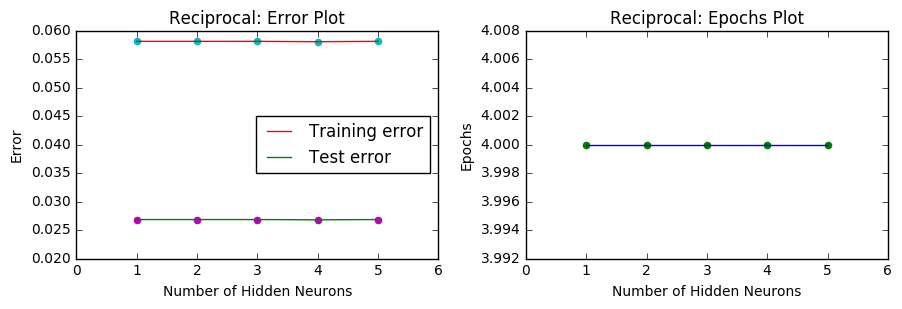

In [13]:
# generating x...
reciprocal_x = np.arange(1, 101, dtype= np.float32).reshape(-1, 1)
# generating y...
reciprocal_y = 1/reciprocal_x
# applying data to neural network..
train_error_r, epochs_r, test_error_r = obtain_performance(
    reciprocal_x, reciprocal_y, hidden_neurons)
plot_results(hidden_neurons, train_error_r, test_error_r, 
             epochs_r, 'Reciprocal' )

## 2) Log_10
$$F(x) = log_{10}x; 1<= x <=10$$

Epoch:  0 ...... Training Error:  0.200062313963
Epoch:  100000 ...... Training Error:  0.0474856172589
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.196812471553
Epoch:  100000 ...... Training Error:  0.00543480431728
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.22629788463
Epoch:  100000 ...... Training Error:  0.00673827028993
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.245094380387
-----------------------------------------------------------
Epoch:  6144 ...... Training Error:  0.00646158972092
Error has converged...
-----------------------------------------------------------
Epoch:  0 .....

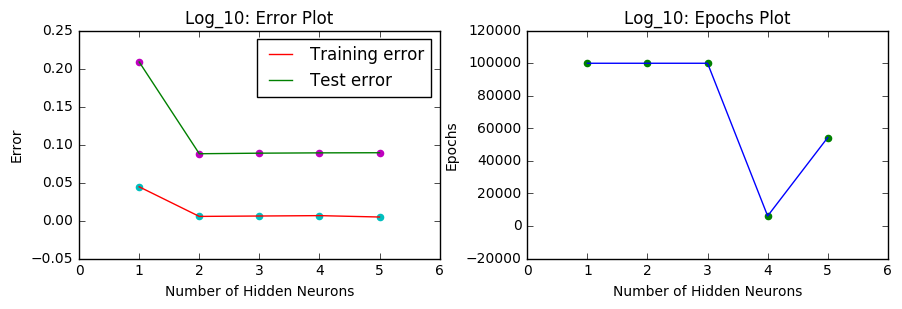

In [14]:
log_x = np.arange(1, 11, dtype= np.float32).reshape(-1, 1)
log_y = np.log10(log_x)
train_error_l, epochs_l, test_error_l = obtain_performance(
    log_x, log_y, hidden_neurons)
plot_results(hidden_neurons, train_error_l, test_error_l, 
             epochs_l, 'Log_10')

## 3) Exponential 
$$F(x) = exp(-x); 1<= x <=10$$

Epoch:  0 ...... Training Error:  0.729610561643
-----------------------------------------------------------
Epoch:  86 ...... Training Error:  0.0346181163291
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.785317682649
-----------------------------------------------------------
Epoch:  54 ...... Training Error:  0.034098362675
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.901437580515
-----------------------------------------------------------
Epoch:  5 ...... Training Error:  0.0337807908547
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.931818466253
-----------------------------------------------------------
Epoch:  33 ...... Training Error:  0.0330509135785
Error has converged...
-----------------------------------------------------------
Epoch:  0 ...... Training Erro

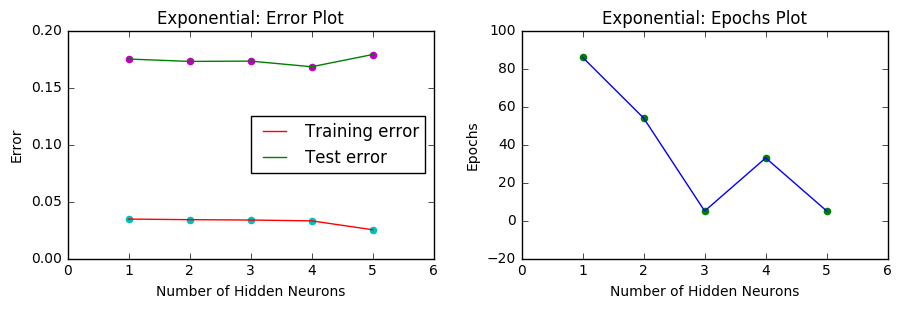

In [15]:
exp_x = np.arange(1, 11, dtype= np.float32).reshape(-1, 1)
exp_y = np.exp(-exp_x)
train_error_e, epochs_e, test_error_e = obtain_performance(
    exp_x, exp_y, hidden_neurons)
plot_results(hidden_neurons, train_error_e, test_error_e, 
             epochs_e, 'Exponential')

## 4) Sinusoid 
$$F(x) = sin(x); 0<= x <=\frac{\pi}{2}$$

Epoch:  0 ...... Training Error:  0.249409410518
Epoch:  100000 ...... Training Error:  0.0671843050992
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.251353417207
Epoch:  100000 ...... Training Error:  0.0428746642237
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.28853769008
Epoch:  100000 ...... Training Error:  0.0398713907209
-----------------------------------------------------------
Max epochs reached...
-----------------------------------------------------------
Epoch:  0 ...... Training Error:  0.315798107827
-----------------------------------------------------------
Epoch:  11704 ...... Training Error:  0.00284031252549
Error has converged...
-----------------------------------------------------------
Epoch:  0 ......

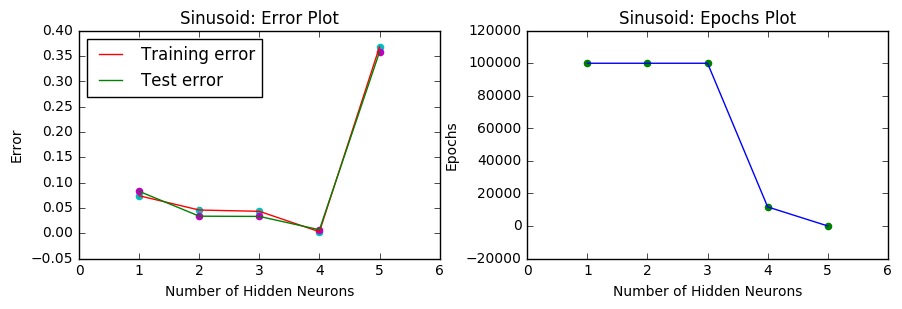

In [16]:
sin_x = np.linspace(0, np.pi/2, dtype= np.float32).reshape(-1, 1)
sin_y = np.sin(sin_x)
train_error_s, epochs_s, test_error_s = obtain_performance(
    sin_x, sin_y, hidden_neurons)
plot_results(hidden_neurons, train_error_s, test_error_s,
             epochs_s, 'Sinusoid')

---